In [62]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from time import sleep
from time import time

In [63]:
# URL pour requêter les 30 derniers jours
url = 'https://fr.trustpilot.com/review/www.cdiscount.com?date=last30days'
html = requests.get(url)

In [64]:
# transformation de la page en un document exploitable
# Selon le parsers choisi (html.parser, lxml, lxml-xml, xml, html5lib)
soup = BeautifulSoup(html.text, 'html.parser')

In [66]:
print(soup)

<!DOCTYPE html>
<html lang="fr-FR"><head><meta charset="utf-8"/><meta content="width=device-width, initial-scale=1" name="viewport"/><link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/favicon.ico" rel="shortcut icon" type="image/x-icon"/><link href="/manifest.json" rel="manifest"/><meta content="Trustpilot" name="application-name"/><meta content="#1c1c1c" name="theme-color"/><link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/><link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/><link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/><link color="#00b67a" href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/safari-pinned-tab.svg" rel="mask-icon"/><meta content="Trustpilot" name="apple-mobile-web-app-title"/><meta content="#1c1c1c" name="msap

### Date du commentaire

In [5]:
# la date à récupérer
date_time = soup.find_all('time', {'class' : ""})
date_time[2]['datetime'][0:19].replace('T', ' ')

'2023-11-26 13:05:41'

### Récupération du pays du commentaire

In [6]:
pays = soup.find_all('div', {"class" : "typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua"})

### commentaire

In [130]:
comment = soup.find_all('p' , {'class' : "typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"})
comment[0].text

"j'ai toujours était satisfait de Cdiscount"

### note

In [8]:
note = soup.find_all('div', {"class" : "styles_reviewHeader__iU9Px"})
print(note[2]['data-service-review-rating'])

5


### scrapping des commentaires des 30 derniers

In [9]:
#Test de l'URL : 200 si OK, 402, si erreur, 403 si non autorisé par le site
requests.get('https://fr.trustpilot.com/review/www.cdiscount.com?date=last30days&page=2').status_code

200

In [117]:
# initialisation de l'heure maintenant 
t0 = time()

# création de la liste des URL des pages regroupant données pour les 30 derniers jours
nb_pages = 50
liste_url = []
page = 1

while page <= nb_pages :
    try :
        if requests.get('https://fr.trustpilot.com/review/www.cdiscount.com?date=last30days&page='+str(page)).status_code==200:
            liste_url.append('https://fr.trustpilot.com/review/www.cdiscount.com?date=last30days&page='+str(page))
    except:
        pass
    page = page + 1

# scapping des données
liste_note = []
liste_commentaire = []
liste_date = []
liste_pays = []

for url in tqdm(liste_url):
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    comment = soup.find_all('p' , {'class' : "typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"})
    note = soup.find_all('div', {"class" : "styles_reviewHeader__iU9Px"})
    pays = soup.find_all('div', {"class" : "typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua"})
    date_time = soup.find_all('time', {'class' : ""})
    
    for nb_avis in range(len(comment)):
        liste_note.append(note[nb_avis]['data-service-review-rating'])
        liste_date.append(date_time[nb_avis]['datetime'][0:19].replace('T', ' '))
        liste_pays.append(pays[nb_avis].span.text)
        
        try :
            liste_commentaire.append(comment[nb_avis].text)
        
        except:
            liste_commentaire.append('NaN')

    sleep(5)

# constitution d'un dictionnaire regroupant les données
dico = {'note' : liste_note, 'commentaire' : liste_commentaire, 'pays' : liste_pays, 'date' : liste_date}

# constitution d'un DataFrame à partir du dictionnaire 
df = pd.DataFrame(dico)

# affichage du temps de calcul par rapport  à l'initialisation en début de requête 
print('le temps de calcul est de {:.2f} secondes'.format(time()-t0))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:04<00:00,  5.17s/it]

le temps de calcul est de 141.13 secondes


In [120]:
df.tail(10)

,note,commentaire,pays,date
367,5,Bonjour pour un retour il faut envoyé un messa...,FR,2023-10-30 12:51:27
368,5,moteur de recherche efficace. Diffèrent prix .,FR,2023-10-30 12:11:35
369,5,Produit jamais livré ! service client catastro...,FR,2023-10-30 11:50:42
370,1,"Bonjour, j'avais sélectionné des articles Cdis...",FR,2023-10-30 09:35:47
371,5,ATTENTION CDISCOUNT SONT VRAIMENT DES VOLEURS ...,FR,2023-10-30 09:27:06
372,1,Très déçu de mon achat vise trop grande qui pa...,LU,2023-10-30 01:45:35
373,5,Vraiment pas fiable au niveau livraison. À cha...,FR,2023-10-29 23:01:54
374,3,Impossible d'écrire un avis défavorable sur Cd...,FR,2023-10-29 22:44:46
375,1,Il n'y a absolument aucun moyen de contacter l...,FR,2023-10-29 21:17:28
376,5,j'ai toujours était satisfait de Cdiscount,FR,2023-10-28 20:21:16


In [131]:
df.head(50)

,note,commentaire,pays,date
0,5,Il y a des années que j'achète chez Cdiscount ...,FR,2023-11-25 23:13:41
1,3,Dans l'ensemble Cdiscount est bien mais a de m...,FR,2023-11-25 23:01:38
2,5,J'ai acheté une j'ai acheté une machine à lave...,FR,2023-11-25 12:02:10
3,4,"Depuis des années, je suis très satisfaite de ...",FR,2023-11-23 07:36:23
4,4,J ATTENDS CE CARBURATEUR AVEC IMPATIENCE EN ES...,FR,2023-11-23 16:04:49
5,5,ça fait plus de 5 ans que j'achète pratiquemen...,FR,2023-11-22 19:10:05
6,3,Dommage que les avis d'insatisfaction ne soit ...,FR,2023-11-23 20:06:02
7,3,"tres bien pour la commande , par cotre j'ai la...",FR,2023-11-24 10:39:25
8,5,Que des bons retours à ce jour. Réactivité et ...,FR,2023-11-26 14:48:02
9,5,cette entreprise est top je suis une cliente f...,FR,2023-11-26 20:42:42


C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


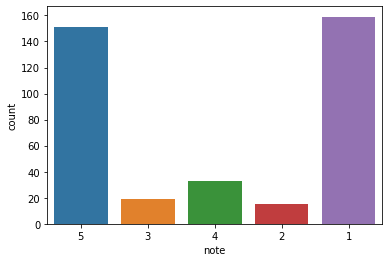

In [132]:
import seaborn as sns
sns.countplot(df['note']);

In [133]:
df.to_csv('datasets/SatisfactionClients/cdiscount_last30days.csv', sep=';')